![MOSEK ApS](https://mosek.com/files/mosek_logo_color.png )

----------------------------------------------------------------------------


Portfolio Optimization: *the efficient frontier*
========================

The aim of this tutorial is two-fold:

1. to illustrate some `Fusion` modeling features
2. to show how to use MOSEK built-in BLAS/LAPACK linear algebra routines.

Problem definition
---------------------------

The classical *Markowitz portfolio optimization* problem considers:

* $n$ stocks or assets $x_i$ held over a single period of time.

* an expected return per assets $\mu_i$

* a covariance matrix for the assets return  $\Sigma$

Thus the portfolio expected return is given by $\mu^T x$ and the risk is measured by $x^T \Sigma x$. 

We want to define an allocation strategy such that:

* all our wealth $w$ must be invested,

* no sells are allowed ($x\geq 0$),

We want to find a good compromise between the return and the risk. A typical approach is maximize the expected return paying some fee for the risk. This is achieved introducing a nonnegative weight $\alpha$ that measures how much we are willing to pay for the risk that we take, i.e. we want to maximize

\begin{equation}
   \mbox{maximize}   \quad \mu^T x - \alpha s
\end{equation}

where $s$ is a variable representing the risk.

Note that:

* the smaller is $\alpha$ the higher is the risk we accept,
* the larger is $\alpha$, the smaller is the risk we accept.

As limit case, for $\alpha=0$ the risk is completely ignored and we obtained the mos

For each given $\alpha$ we find a pair $s,x$ that defines a curve named the *efficient frontier.*

The model is formulated as follows:

\begin{equation}
   \begin{array}{lll}
   \mbox{maximize}   & \mu^T x - \alpha s& \\
   \mbox{subject to} &  e^T x            & =     w,\\
                     &  s^2 \geq x^T \Sigma x,\\
                     &  x                & \geq  0.
   \end{array}
\end{equation}


Conversion in Conic form
------------------------------

The covariance matrix $\Sigma$ is positive semidefinite by definition and therefore there exist a matrix $G$ such that

\begin{equation}
   \Sigma = G G^T.
\end{equation}
 
In general the choice of $G$ is **not** unique and one possible choice of $G$ is the Cholesky factorization of $\Sigma$. For a given $G$ we have that

\begin{equation}
   \begin{array}{lll}
   x^T \Sigma x & = & x^T G G^T x \\
                & = & \left\|G^T x\right\|^2.
   \end{array}
\end{equation}

Hence, we may write the risk constraint as

\begin{equation}
   s^2 \geq \left\|G^T x\right\|_2
\end{equation}

or equivalently

\begin{equation}
 \left[s;G^T x\right] \in Q^{n+1}.
\end{equation}

where $Q^{n+1}$ is the $n+1$ dimensional quadratic cone. Therefore, problem can be written as


\begin{equation}
   \begin{array}{lll}
   \mbox{maximize}   & \mu^T x - \alpha s& \\
   \mbox{subject to} &  e^T x            & =     w,\\
                     &  [s;G^T x]        & \in   Q^{n+1},\\
                     &  x                & \geq  0.
   \end{array}
\end{equation}

which is a conic quadratic optimization problem that can easily be formulated and solved with `Fusion`.

Implementation
----------------------------

First of all we need some input:

In [28]:
n  = 3

mu = [0.1073, 0.0737, 0.0627]

w  = 1.0

# stored in a single 1-D array in column-major order
Sigma = [\
    0.02778 ,   0.00387 ,  0.00021,\
    0.00387 ,   0.01112 , -0.00020,\
    0.00021 ,  -0.00020 ,  0.00115 \
    ]


The Cholesky factor $G$ of $\Sigma$ can be easily computed. 

We use the built-in `LAPACK potrf` function provided by MOSEK optimizer API:

In [27]:
import mosek as msk

with msk.Env() as env:
    env.potrf( msk.uplo.lo,n, Sigma)
    
#copying in a 2D array and zeroing out the lower triangular part
GT = [ [ 0. if j<i else Sigma[i+j*n] for j in range(n)] for i in range(n)]
    
for i in range(n):
    print "| %s |" % ','.join(['%+.4f'% GT[i][j] for j in range(n)])

| +0.4083,+0.0039,+0.0002 |
| +0.0000,+0.3156,-0.0002 |
| +0.0000,+0.0000,+0.1837 |


The model can be easily implemented in `fusion`:

In [20]:
from mosek.fusion import *

def EfficientFrontier(mu,GT,w,alphas):
    
    n = len(mu)
    
    with Model("Efficient frontier") as M:

        # Defines the variables (holdings). Shortselling is not allowed.
        x = M.variable("x", n, Domain.greaterThan(0.0)) # Portfolio variables
        s = M.variable("s", 1, Domain.unbounded()) # Risk variable

        M.constraint('budget', Expr.sum(x), Domain.equalsTo(w))

        M.constraint('risk', Expr.vstack(s,Expr.mul(GT,x)),Domain.inQCone())

        risk = []
        xs = []
        
        mudotx = Expr.dot(mu,x)
        for alpha in alphas:

            #  Define objective as a weighted combination of return and risk
            M.objective('obj', ObjectiveSense.Maximize, Expr.sub(mudotx,Expr.mul(alpha,s)))

            M.solve()

            risk.append(s.level()[0])
            xs.append(x.level())
            
        return risk,xs

We will now make some test for a given set of $\alpha$'s.

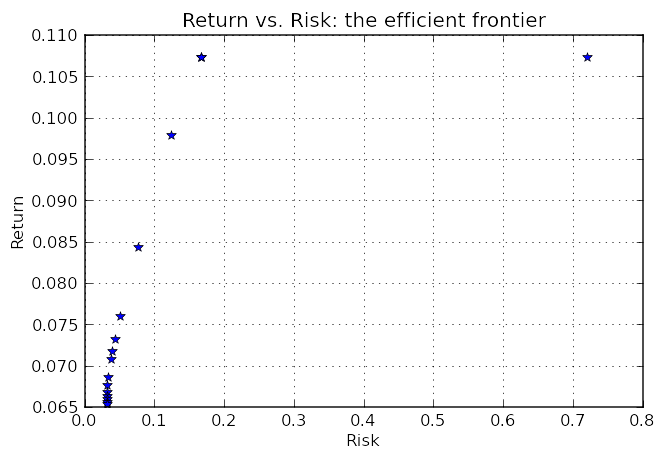

In [21]:
alphas = [0.00, 0.01, 0.10, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.75, 1.00, 1.50, 2.00, 3.00, 5.00, 10.00]

risk,xs = EfficientFrontier(mu,GT,w,alphas)

%matplotlib inline
import matplotlib.pyplot as plt

plt.rc('savefig',dpi=120)

returns = [ dot(mu,xx) for xx in xs]
plt.plot( risk, returns , 'b*')
plt.grid()    
plt.xlabel('Risk')
plt.ylabel('Return')
plt.title("Return vs. Risk: the efficient frontier")

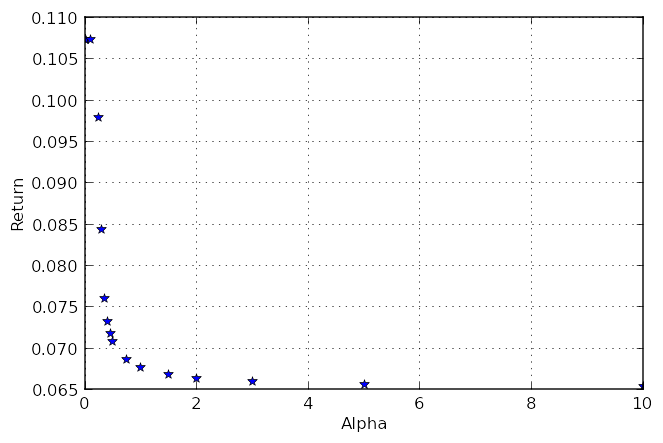

In [29]:
plt.plot( alphas, [ dot(mu,xx) for xx in xs], 'b*')
plt.grid()    
plt.xlabel('Alpha')
plt.ylabel('Return')

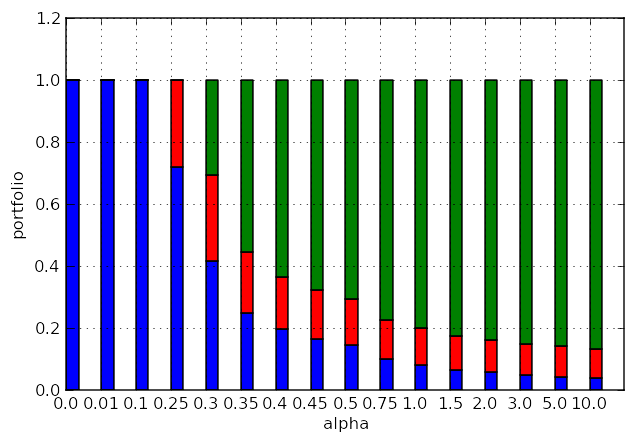

In [25]:
m = len(alphas)
indx= range(m)
colors=['b','r','g']
bott = [0. for i in indx]

for i in range(n):
    xx = [ xs[j][i] for j in indx]
    plt.bar(indx, xx ,  0.35, bottom=bott,color=colors[i])
    bott= [ bott[j] + xx[j] for j in indx]

plt.xticks(indx, alphas)
plt.xlabel('alpha')
plt.ylabel('portfolio')
plt.grid()
plt.show()

*Disclaimer*
The code in this tutorial is provided as is. Future versions of MOSEK and `Fusion` may be not fully compatible. 



<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by <a xmlns:cc="http://creativecommons.org/ns#" href="www.mosek.com" property="cc:attributionName" rel="cc:attributionURL">MOSEK ApS</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.<br />Based on a work at <a xmlns:dct="http://purl.org/dc/terms/" href="www.mosek.com" rel="dct:source">www.mosek.com</a>.